# Predicting Noise (complaints)
#### Author: Sung Hoon Yang @ NYU

*Below is the abstract of the paper for which the prediction was conducted*

Noise in New York City is increasingly unbearable as evidenced by a growing number of noise complaints, while responses to noise complaints and therefore enforcement of The Noise Code has been hampered due to inability to handle sheer volumes. This capstone project aims to provide a data-driven optimization approach to improve the New York City Department of Environmental Protection’s (DEP) current scheduling process to better address noise complaints. To accomplish this, we will use machine learning to predict noise complaints and qualities that lead to violations for scheduling and routing optimization. Based on our discussion with DEP sponsors and preliminary analysis of 311 complaints, we suspect that our model will improve DEP metrics and that construction-related permits will be of highest variable importance to predicting and determining the validity of noise complaints. The implications of this analysis will allow DEP inspectors to improve time to complaint resolution, vanquish their backlog of complaints, and increase their issuance of violations.

Using publicly available data, we will build a neural network model to predict daily noise complaints per spatial bin as demarcated by Neighborhood Tabulation Areas. In this particular model, I will build a model that predicts the number of daily complaints that pertain to DEP's overseeing per 29 polygons of Manhattan. Below is the complete list of features, followed by that of spatial bins as demarcated by NTA shapefile.


### Features
* **wknd**: Weekend flag
* **holiday**: Holiday flag
* **hours_to_resolution_stdz**: Hours to Resolution standardized annually
* **AWND**: Average daily wind speed (tenths of meters per second)
* **PRCP**: Precipitation (tenths of mm) 
* **SNOW**: Snowfall (mm) 
* **SNWD**: Snow depth (mm) 
* **TMAX**: Maximum temperature (tenths of degrees C)
* **WDF5**: Direction of fastest 5-second wind (degrees)
* **WSF5**: Fastest 5-second wind speed (tenths of meters per second) 
* **d-1_cnt**: Complaint count of D-1
* **d-2_cnt**: Complaint count of D-2
* **d-3_cnt**: Complaint count of D-3
* **d-4_cnt**: Complaint count of D-4
* **d-5_cnt**: Complaint count of D-5
* **d-6_cnt**: Complaint count of D-6
* **d-7_cnt**: Complaint count of D-7
* **d-8_cnt**: Complaint count of D-8
* **d-9_cnt**: Complaint count of D-9
* **d-10_cnt**: Complaint count of D-10
* **d-11_cnt**: Complaint count of D-11
* **d-12_cnt**: Complaint count of D-12
* **d-13_cnt**: Complaint count of D-13
* **d-14_cnt**: Complaint count of D-14
* **d-15_cnt**: Complaint count of D-15
* **d-16_cnt**: Complaint count of D-16
* **d-17_cnt**: Complaint count of D-17
* **d-18_cnt**: Complaint count of D-18
* **d-19_cnt**: Complaint count of D-19
* **d-20_cnt**: Complaint count of D-20
* **d-21_cnt**: Complaint count of D-21
* **d-22_cnt**: Complaint count of D-22
* **d-23_cnt**: Complaint count of D-23
* **d-24_cnt**: Complaint count of D-24
* **d-25_cnt**: Complaint count of D-25
* **d-26_cnt**: Complaint count of D-26
* **d-27_cnt**: Complaint count of D-27
* **d-28_cnt**: Complaint count of D-28
* **ahv_open_cnt**: after hour variance open count
* **WT01**: unknown weather feature (omitted from data dictionary, but included)
* **WT02**: unknown weather feature (omitted from data dictionary, but included)
* **WT04**: unknown weather feature (omitted from data dictionary, but included)
* **WT08**: unknown weather feature (omitted from data dictionary, but included)

### Spatial Bins

* **MN01**:	Marble Hill-Inwood
* **MN03**:	Central Harlem North-Polo Grounds
* **MN04**:	Hamilton Heights
* **MN06**:	Manhattanville
* **MN09**:	Morningside Heights
* **MN11**:	Central Harlem South
* **MN12**:	Upper West Side
* **MN13**:	Hudson Yards-Chelsea-Flatiron-Union Square
* **MN14**:	Lincoln Square
* **MN15**:	Clinton
* **MN17**:	Midtown-Midtown South
* **MN19**:	Turtle Bay-East Midtown
* **MN20**:	Murray Hill-Kips Bay
* **MN21**:	Gramercy
* **MN22**:	East Village
* **MN23**:	West Village
* **MN24**:	SoHo-TriBeCa-Civic Center-Little Italy
* **MN25**:	Battery Park City-Lower Manhattan
* **MN27**:	Chinatown
* **MN28**:	Lower East Side
* **MN31**:	Lenox Hill-Roosevelt Island
* **MN32**:	Yorkville
* **MN33**:	East Harlem South
* **MN34**:	East Harlem North
* **MN35**:	Washington Heights North
* **MN36**:	Washington Heights South
* **MN40**:	Upper East Side-Carnegie Hill
* **MN50**:	Stuyvesant Town-Cooper Village
* **MN99**:	park-cemetery-etc-Manhattan

In [1]:
#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
#wrangling
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import geopandas as gpd
from itertools import product
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scipy
#dt
import datetime
from dateutil.relativedelta import relativedelta
#user setting
import sys
sys.path.insert(0, './analysis/311/duke')
# precipitation data
from prep_dta import _2010, _2011, _2012, _2013, _2014, _2015, _2016, _2017, _2018
from american_holidays import american_holidays as _american_holidays_str
#viz
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [27]:
__DATA_FILE_PATH__ = r'/Users/sunghoonyang/Google Drive/Noise Capstone/data/dep_ntanm_noise_only_311_data/NTANM_DEP_NZONLY_311_Service_Requests_from_2010_to_Present.csv'
def _convert_dt(dt):
    try:
        return pd.to_datetime(dt, format='%Y-%m-%d %H:%M:%S')
    except:
        return np.nan


__RAW_DF__ = pd.read_csv(
    __DATA_FILE_PATH__
    , converters={k: _convert_dt for k in ['Created Date', 'Closed Date']}
)
__RAW_DF__ = __RAW_DF__[__RAW_DF__['boro_name'] == 'Manhattan']
__RAW_DF__.head()

/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Address Type,City,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Latitude,Longitude,Location,geom,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng
14520,2017-09-12 22:56:00,2017-09-20 00:45:00,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),10022.0,EAST 59 STREET,EAST 59 STREET,PARK AVENUE,LEXINGTON AVENUE,BLOCKFACE,NEW YORK,Closed,NaN,The Department of Environmental Protection did...,2017-09-20 00:45:00,08 MANHATTAN,NaN,MANHATTAN,992854.0,217094.0,PHONE,Unspecified,MANHATTAN,40.762545,-73.968941,"(40.76254513902991, -73.96894094768926)",POINT (-73.96894094768926 40.76254513902991),1.0,Manhattan,61,MN19,Turtle Bay-East Midtown,1.739327e+07,21412.598185
14521,2017-09-12 21:22:00,NaT,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),10017.0,321 EAST 45 STREET,EAST 45 STREET,2 AVE,1 AVE,ADDRESS,NEW YORK,Started,NaN,The Department of Environmental Protection has...,2017-09-19 20:24:00,06 MANHATTAN,1.013380e+09,MANHATTAN,992529.0,213060.0,ONLINE,Unspecified,MANHATTAN,40.751473,-73.970119,"(40.751473149083694, -73.97011911255234)",POINT (-73.97011911255234 40.75147314908369),1.0,Manhattan,61,MN19,Turtle Bay-East Midtown,1.739327e+07,21412.598185
14522,2017-09-13 23:53:00,2017-09-20 21:30:00,DEP,Department of Environmental Protection,Noise,Noise: Construction Equipment (NC1),10022.0,NaN,NaN,NaN,NaN,INTERSECTION,NEW YORK,Closed,NaN,The Department of Environmental Protection did...,2017-09-20 21:30:00,05 MANHATTAN,NaN,MANHATTAN,992159.0,215346.0,PHONE,Unspecified,MANHATTAN,40.757748,-73.971452,"(40.757747976454525, -73.9714518418555)",POINT (-73.9714518418555 40.75774797645452),1.0,Manhattan,61,MN19,Turtle Bay-East Midtown,1.739327e+07,21412.598185
14523,2017-09-13 01:24:00,2017-09-20 01:45:00,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),10022.0,318 EAST 55 STREET,EAST 55 STREET,2 AVE,1 AVE,ADDRESS,NEW YORK,Closed,NaN,The Department of Environmental Protection did...,2017-09-20 01:45:00,06 MANHATTAN,1.013470e+09,MANHATTAN,993784.0,215337.0,PHONE,Unspecified,MANHATTAN,40.757722,-73.965586,"(40.757721670832105, -73.96558628974037)",POINT (-73.96558628974037 40.7577216708321),1.0,Manhattan,61,MN19,Turtle Bay-East Midtown,1.739327e+07,21412.598185
14524,2017-09-14 18:11:00,2017-09-21 01:30:00,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),10016.0,685 1 AVENUE,1 AVENUE,E 39 ST,E 40 ST,ADDRESS,NEW YORK,Closed,NaN,The Department of Environmental Protection did...,2017-09-21 01:30:00,06 MANHATTAN,1.009450e+09,MANHATTAN,992238.0,211437.0,PHONE,Unspecified,MANHATTAN,40.747019,-73.971171,"(40.747018691029226, -73.97117132877398)",POINT (-73.97117132877398 40.74701869102923),1.0,Manhattan,61,MN19,Turtle Bay-East Midtown,1.739327e+07,21412.598185


Create a `geometry` column to convert `df` into `GeoDataFrame`

In [28]:
from shapely.geometry import Point

crs = {'init': 'epsg:4326'}
df = __RAW_DF__.copy(deep=True)

def _return_pt(xy):
    try:
        return Point(*reversed(eval(str(xy))))
    except:
        return np.nan

df['geom'] = df['Location'].apply(_return_pt)
df.head()

,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Address Type,City,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Latitude,Longitude,Location,geom,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng
14520,2017-09-12 22:56:00,2017-09-20 00:45:00,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),10022.0,EAST 59 STREET,EAST 59 STREET,PARK AVENUE,LEXINGTON AVENUE,BLOCKFACE,NEW YORK,Closed,NaN,The Department of Environmental Protection did...,2017-09-20 00:45:00,08 MANHATTAN,NaN,MANHATTAN,992854.0,217094.0,PHONE,Unspecified,MANHATTAN,40.762545,-73.968941,"(40.76254513902991, -73.96894094768926)",POINT (-73.96894094768926 40.76254513902991),1.0,Manhattan,61,MN19,Turtle Bay-East Midtown,1.739327e+07,21412.598185
14521,2017-09-12 21:22:00,NaT,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),10017.0,321 EAST 45 STREET,EAST 45 STREET,2 AVE,1 AVE,ADDRESS,NEW YORK,Started,NaN,The Department of Environmental Protection has...,2017-09-19 20:24:00,06 MANHATTAN,1.013380e+09,MANHATTAN,992529.0,213060.0,ONLINE,Unspecified,MANHATTAN,40.751473,-73.970119,"(40.751473149083694, -73.97011911255234)",POINT (-73.97011911255234 40.75147314908369),1.0,Manhattan,61,MN19,Turtle Bay-East Midtown,1.739327e+07,21412.598185
14522,2017-09-13 23:53:00,2017-09-20 21:30:00,DEP,Department of Environmental Protection,Noise,Noise: Construction Equipment (NC1),10022.0,NaN,NaN,NaN,NaN,INTERSECTION,NEW YORK,Closed,NaN,The Department of Environmental Protection did...,2017-09-20 21:30:00,05 MANHATTAN,NaN,MANHATTAN,992159.0,215346.0,PHONE,Unspecified,MANHATTAN,40.757748,-73.971452,"(40.757747976454525, -73.9714518418555)",POINT (-73.9714518418555 40.75774797645452),1.0,Manhattan,61,MN19,Turtle Bay-East Midtown,1.739327e+07,21412.598185
14523,2017-09-13 01:24:00,2017-09-20 01:45:00,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),10022.0,318 EAST 55 STREET,EAST 55 STREET,2 AVE,1 AVE,ADDRESS,NEW YORK,Closed,NaN,The Department of Environmental Protection did...,2017-09-20 01:45:00,06 MANHATTAN,1.013470e+09,MANHATTAN,993784.0,215337.0,PHONE,Unspecified,MANHATTAN,40.757722,-73.965586,"(40.757721670832105, -73.96558628974037)",POINT (-73.96558628974037 40.7577216708321),1.0,Manhattan,61,MN19,Turtle Bay-East Midtown,1.739327e+07,21412.598185
14524,2017-09-14 18:11:00,2017-09-21 01:30:00,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),10016.0,685 1 AVENUE,1 AVENUE,E 39 ST,E 40 ST,ADDRESS,NEW YORK,Closed,NaN,The Department of Environmental Protection did...,2017-09-21 01:30:00,06 MANHATTAN,1.009450e+09,MANHATTAN,992238.0,211437.0,PHONE,Unspecified,MANHATTAN,40.747019,-73.971171,"(40.747018691029226, -73.97117132877398)",POINT (-73.97117132877398 40.74701869102923),1.0,Manhattan,61,MN19,Turtle Bay-East Midtown,1.739327e+07,21412.598185


In [29]:
gdf = gpd.GeoDataFrame(df, crs=crs, geometry='geom')

## shapefile

<Figure size 864x576 with 0 Axes>

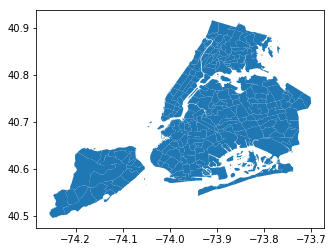

In [30]:
fig = plt.figure(figsize=(12, 8))
shp = gpd.read_file('/Users/sunghoonyang/Google Drive/Noise Capstone/data/Neighborhood Tabulation Areas/geo_export_734cc588-a881-4394-bdd7-9f757b306aa4.shp')
shp.plot()

## Spatial Join DEP Noise complaints with NTA Shapefile

In [31]:
noise_nb_label = gpd.sjoin(
    gdf
    , shp
    , op='within'
)

noise_nb_label.head()

,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Address Type,City,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Latitude,Longitude,Location,geom,boro_code_left,boro_name_left,county_fip_left,ntacode_left,ntaname_left,shape_area_left,shape_leng_left,index_right,boro_code_right,boro_name_right,county_fip_right,ntacode_right,ntaname_right,shape_area_right,shape_leng_right
14520,2017-09-12 22:56:00,2017-09-20 00:45:00,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),10022.0,EAST 59 STREET,EAST 59 STREET,PARK AVENUE,LEXINGTON AVENUE,BLOCKFACE,NEW YORK,Closed,NaN,The Department of Environmental Protection did...,2017-09-20 00:45:00,08 MANHATTAN,NaN,MANHATTAN,992854.0,217094.0,PHONE,Unspecified,MANHATTAN,40.762545,-73.968941,"(40.76254513902991, -73.96894094768926)",POINT (-73.96894094768926 40.76254513902991),1.0,Manhattan,61,MN19,Turtle Bay-East Midtown,1.739327e+07,21412.598185,11,1.0,Manhattan,061,MN19,Turtle Bay-East Midtown,1.739327e+07,21412.598185
14521,2017-09-12 21:22:00,NaT,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),10017.0,321 EAST 45 STREET,EAST 45 STREET,2 AVE,1 AVE,ADDRESS,NEW YORK,Started,NaN,The Department of Environmental Protection has...,2017-09-19 20:24:00,06 MANHATTAN,1.013380e+09,MANHATTAN,992529.0,213060.0,ONLINE,Unspecified,MANHATTAN,40.751473,-73.970119,"(40.751473149083694, -73.97011911255234)",POINT (-73.97011911255234 40.75147314908369),1.0,Manhattan,61,MN19,Turtle Bay-East Midtown,1.739327e+07,21412.598185,11,1.0,Manhattan,061,MN19,Turtle Bay-East Midtown,1.739327e+07,21412.598185
14522,2017-09-13 23:53:00,2017-09-20 21:30:00,DEP,Department of Environmental Protection,Noise,Noise: Construction Equipment (NC1),10022.0,NaN,NaN,NaN,NaN,INTERSECTION,NEW YORK,Closed,NaN,The Department of Environmental Protection did...,2017-09-20 21:30:00,05 MANHATTAN,NaN,MANHATTAN,992159.0,215346.0,PHONE,Unspecified,MANHATTAN,40.757748,-73.971452,"(40.757747976454525, -73.9714518418555)",POINT (-73.9714518418555 40.75774797645452),1.0,Manhattan,61,MN19,Turtle Bay-East Midtown,1.739327e+07,21412.598185,11,1.0,Manhattan,061,MN19,Turtle Bay-East Midtown,1.739327e+07,21412.598185
14523,2017-09-13 01:24:00,2017-09-20 01:45:00,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),10022.0,318 EAST 55 STREET,EAST 55 STREET,2 AVE,1 AVE,ADDRESS,NEW YORK,Closed,NaN,The Department of Environmental Protection did...,2017-09-20 01:45:00,06 MANHATTAN,1.013470e+09,MANHATTAN,993784.0,215337.0,PHONE,Unspecified,MANHATTAN,40.757722,-73.965586,"(40.757721670832105, -73.96558628974037)",POINT (-73.96558628974037 40.7577216708321),1.0,Manhattan,61,MN19,Turtle Bay-East Midtown,1.739327e+07,21412.598185,11,1.0,Manhattan,061,MN19,Turtle Bay-East Midtown,1.739327e+07,21412.598185
14524,2017-09-14 18:11:00,2017-09-21 01:30:00,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),10016.0,685 1 AVENUE,1 AVENUE,E 39 ST,E 40 ST,ADDRESS,NEW YORK,Closed,NaN,The Department of Environmental Protection did...,2017-09-21 01:30:00,06 MANHATTAN,1.009450e+09,MANHATTAN,992238.0,211437.0,PHONE,Unspecified,MANHATTAN,40.747019,-73.971171,"(40.747018691029226, -73.97117132877398)",POINT (-73.97117132877398 40.74701869102923),1.0,Manhattan,61,MN19,Turtle Bay-East Midtown,1.739327e+07,21412.598185,11,1.0,Manhattan,061,MN19,Turtle Bay-East Midtown,1.739327e+07,21412.598185


## Group by Day

In [32]:
noise_nb_label.index = noise_nb_label['Created Date']
df = noise_nb_label
df = df.groupby([pd.Grouper(freq='d'), 'ntacode_right']).count()
df.rename(mapper={
    'Created Date': 'complaint_cnt'
}, inplace=True, axis=1)
df.reset_index(inplace=True)
df = df.iloc[:, 0:3]
df.rename(mapper={
    'ntacode_right': 'ntacode'
    , 'Created Date': 'created_dt'
}, inplace=True, axis=1)
df.head()

,created_dt,ntacode,complaint_cnt
0,2010-01-01,MN14,2
1,2010-01-01,MN31,1
2,2010-01-01,MN32,1
3,2010-01-02,MN12,2
4,2010-01-02,MN14,1


In [33]:
# create a complete cartesian of created dates of complaints and spatial bins
indices = pd.DataFrame(
    list(product(df['created_dt'].unique(), df['ntacode'].unique()))
    , columns=['created_dt', 'ntacode']
)
df = indices.merge(df, how='left')


## Create time features
* holiday
* weekend

In [34]:
df.day = df.created_dt.apply(lambda dt: dt.strftime("%A"))

def is_wknd(s):
    return 1 if s in ('Saturday', 'Sunday') else 0

df['wknd'] = df.day.apply(is_wknd)
df.head()

/Users/sunghoonyang/PycharmProjects/ds_workspace/.ds_py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


,created_dt,ntacode,complaint_cnt,wknd
0,2010-01-01,MN14,2.0,0
1,2010-01-01,MN31,1.0,0
2,2010-01-01,MN32,1.0,0
3,2010-01-01,MN12,NaN,0
4,2010-01-01,MN20,NaN,0


In [35]:
american_holidays = pd.read_csv(pd.compat.StringIO(_american_holidays_str), names=['', 'dt', 'nm'], index_col=0)
american_holidays.dt = american_holidays.dt.apply(lambda dt: datetime.datetime.strptime(dt, '%Y-%m-%d'))
american_holidays_10yrs_bk = american_holidays.copy(deep=True)
american_holidays_10yrs_bk.dt = american_holidays_10yrs_bk.dt.apply(lambda dt: dt - relativedelta(years=10))
holidays = pd.concat([american_holidays_10yrs_bk, american_holidays])


df = df.merge(holidays, left_on='created_dt', right_on='dt', how='left').fillna(0).drop(labels=['dt'], axis=1)
def nm_to_1(s):
    if s != 0:
        return 1
    else:
        return 0


df.nm = df.nm.apply(nm_to_1)
df.rename(mapper={'nm': 'holiday'}, axis=1, inplace=True)

df.head()

,created_dt,ntacode,complaint_cnt,wknd,holiday
0,2010-01-01,MN14,2.0,0,1
1,2010-01-01,MN31,1.0,0,1
2,2010-01-01,MN32,1.0,0,1
3,2010-01-01,MN12,0.0,0,1
4,2010-01-01,MN20,0.0,0,1


## Backlog hours to resolution

In [36]:
hr_to_res_df = __RAW_DF__.copy(deep=True)
hr_to_res_df = hr_to_res_df[hr_to_res_df['Agency']=='DEP']
hr_to_res_df['Hours to Resolution'] = (hr_to_res_df['Closed Date'] - hr_to_res_df['Created Date']).astype('timedelta64[h]')
hr_to_res_df = hr_to_res_df[hr_to_res_df['Hours to Resolution']>=0]
hr_to_res_df['Weekday'] = hr_to_res_df['Created Date'].dt.day_name()
hr_to_res_df['Weekday Num'] = hr_to_res_df['Created Date'].dt.weekday
hr_to_res_df['Creation Hour'] = hr_to_res_df['Created Date'].dt.hour
hr_to_res_df.columns = hr_to_res_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
hr_to_res_df['created_month'] = hr_to_res_df['created_date'].dt.month
hr_to_res_df['created_month_name'] = hr_to_res_df['created_date'].dt.month_name()


hr_to_res_df['created_dt'] = hr_to_res_df['created_date'].apply(lambda dt: dt.strftime('%Y-%m-%d'))
bklg_hr_to_res = hr_to_res_df.groupby([
    'created_dt'
]).agg({
    'hours_to_resolution': 'mean'
})#['hours_to_resolution']
bklg_hr_to_res.reset_index(inplace=True)
bklg_hr_to_res['created_dt'] = bklg_hr_to_res['created_dt'].apply(lambda dt: datetime.datetime.strptime(dt,'%Y-%m-%d'))
bklg_hr_to_res.head()

,created_dt,hours_to_resolution
0,2010-01-01,99.750000
1,2010-01-02,214.500000
2,2010-01-03,270.857143
3,2010-01-04,1174.153846
4,2010-01-05,173.894737


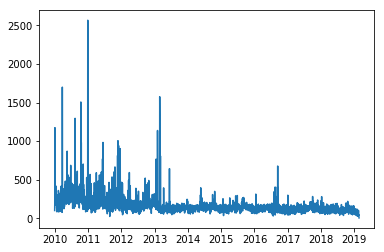

In [37]:
plt.plot(
    bklg_hr_to_res['created_dt']
    , np.array(bklg_hr_to_res['hours_to_resolution']).reshape(-1, 1)
)

Since the first two year has a noticeably bigger magnitude, I will standardize by year.

In [38]:
bklg_hr_to_res_2010 = bklg_hr_to_res[(bklg_hr_to_res['created_dt']>='2010-01-01')&(bklg_hr_to_res['created_dt']<='2010-12-31')]
bklg_hr_to_res_2010['hours_to_resolution_stdz'] = StandardScaler().fit_transform(np.array(bklg_hr_to_res_2010['hours_to_resolution']).reshape(-1, 1))
bklg_hr_to_res_2011 = bklg_hr_to_res[(bklg_hr_to_res['created_dt']>='2011-01-01')&(bklg_hr_to_res['created_dt']<='2011-12-31')]
bklg_hr_to_res_2011['hours_to_resolution_stdz'] = StandardScaler().fit_transform(np.array(bklg_hr_to_res_2011['hours_to_resolution']).reshape(-1, 1))
bklg_hr_to_res_2012 = bklg_hr_to_res[(bklg_hr_to_res['created_dt']>='2012-01-01')&(bklg_hr_to_res['created_dt']<='2012-12-31')]
bklg_hr_to_res_2012['hours_to_resolution_stdz'] = StandardScaler().fit_transform(np.array(bklg_hr_to_res_2012['hours_to_resolution']).reshape(-1, 1))
bklg_hr_to_res_2013 = bklg_hr_to_res[(bklg_hr_to_res['created_dt']>='2013-01-01')&(bklg_hr_to_res['created_dt']<='2013-12-31')]
bklg_hr_to_res_2013['hours_to_resolution_stdz'] = StandardScaler().fit_transform(np.array(bklg_hr_to_res_2013['hours_to_resolution']).reshape(-1, 1))
bklg_hr_to_res_2014 = bklg_hr_to_res[(bklg_hr_to_res['created_dt']>='2014-01-01')&(bklg_hr_to_res['created_dt']<='2014-12-31')]
bklg_hr_to_res_2014['hours_to_resolution_stdz'] = StandardScaler().fit_transform(np.array(bklg_hr_to_res_2014['hours_to_resolution']).reshape(-1, 1))
bklg_hr_to_res_2015 = bklg_hr_to_res[(bklg_hr_to_res['created_dt']>='2015-01-01')&(bklg_hr_to_res['created_dt']<='2015-12-31')]
bklg_hr_to_res_2015['hours_to_resolution_stdz'] = StandardScaler().fit_transform(np.array(bklg_hr_to_res_2015['hours_to_resolution']).reshape(-1, 1))
bklg_hr_to_res_2016 = bklg_hr_to_res[(bklg_hr_to_res['created_dt']>='2016-01-01')&(bklg_hr_to_res['created_dt']<='2016-12-31')]
bklg_hr_to_res_2016['hours_to_resolution_stdz'] = StandardScaler().fit_transform(np.array(bklg_hr_to_res_2016['hours_to_resolution']).reshape(-1, 1))
bklg_hr_to_res_2017 = bklg_hr_to_res[(bklg_hr_to_res['created_dt']>='2017-01-01')&(bklg_hr_to_res['created_dt']<='2017-12-31')]
bklg_hr_to_res_2017['hours_to_resolution_stdz'] = StandardScaler().fit_transform(np.array(bklg_hr_to_res_2017['hours_to_resolution']).reshape(-1, 1))
bklg_hr_to_res_2018 = bklg_hr_to_res[(bklg_hr_to_res['created_dt']>='2018-01-01')&(bklg_hr_to_res['created_dt']<='2018-12-31')]
bklg_hr_to_res_2018['hours_to_resolution_stdz'] = StandardScaler().fit_transform(np.array(bklg_hr_to_res_2018['hours_to_resolution']).reshape(-1, 1))
bklg_hr_to_res_2019 = bklg_hr_to_res[(bklg_hr_to_res['created_dt']>='2019-01-01')&(bklg_hr_to_res['created_dt']<='2019-12-31')]
bklg_hr_to_res_2019['hours_to_resolution_stdz'] = StandardScaler().fit_transform(np.array(bklg_hr_to_res_2019['hours_to_resolution']).reshape(-1, 1))

bklg_hr_to_res_stdz = pd.concat(
	[bklg_hr_to_res_2010
	, bklg_hr_to_res_2011
	, bklg_hr_to_res_2012
	, bklg_hr_to_res_2013
	, bklg_hr_to_res_2014
	, bklg_hr_to_res_2015
	, bklg_hr_to_res_2016
	, bklg_hr_to_res_2017
	, bklg_hr_to_res_2018
	, bklg_hr_to_res_2019]
)
bklg_hr_to_res_stdz.head()


/Users/sunghoonyang/PycharmProjects/ds_workspace/.ds_py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/sunghoonyang/PycharmProjects/ds_workspace/.ds_py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/sunghoonyang/PycharmProjects/ds_workspace/.ds_py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

,created_dt,hours_to_resolution,hours_to_resolution_stdz
0,2010-01-01,99.750000,-0.896004
1,2010-01-02,214.500000,-0.341759
2,2010-01-03,270.857143,-0.069552
3,2010-01-04,1174.153846,4.293395
4,2010-01-05,173.894737,-0.537883


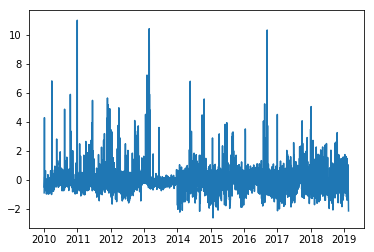

In [39]:
plt.plot(
    bklg_hr_to_res_stdz['created_dt']
    , bklg_hr_to_res_stdz['hours_to_resolution_stdz']
)

In [40]:
bklg_hr_to_res_stdz.drop(labels=['hours_to_resolution'], axis=1, inplace=True)
df = df.merge(
    bklg_hr_to_res_stdz
    , how='left'
)
df.head()

,created_dt,ntacode,complaint_cnt,wknd,holiday,hours_to_resolution_stdz
0,2010-01-01,MN14,2.0,0,1,-0.896004
1,2010-01-01,MN31,1.0,0,1,-0.896004
2,2010-01-01,MN32,1.0,0,1,-0.896004
3,2010-01-01,MN12,0.0,0,1,-0.896004
4,2010-01-01,MN20,0.0,0,1,-0.896004


## Temperature Data
Data from [NOAA](https://www.noaa.gov/)

In [41]:
tmp_1001_1304 = '/Users/sunghoonyang/Google Drive/Noise Capstone/data/temperature/201001-201304.csv'
tmp_1305_1704 = '/Users/sunghoonyang/Google Drive/Noise Capstone/data/temperature/201305-201704.csv'
tmp_1705_1903 = '/Users/sunghoonyang/Google Drive/Noise Capstone/data/temperature/201705-201903.csv'


def prc_csv(f):
    _df = pd.read_csv(
            f
            , header=0
            , parse_dates=['DATE']
        )
    _df = _df[_df['STATION'] == 'USW00094728'].fillna(0)
    return _df
    
tmp_df = pd.concat(
    [
        prc_csv(f) for f in [tmp_1001_1304, tmp_1305_1704, tmp_1705_1903]
    ], ignore_index = True
)


# no null values
tmp_df = tmp_df[tmp_df.columns[np.where(~np.any(pd.isnull(tmp_df), axis=0))]]
tmp_df.drop(labels=['NAME', 'STATION'], axis=1, inplace=True)
df = df.merge(tmp_df, left_on='created_dt', right_on='DATE').drop(labels=['DATE'], axis=1)


df.head()

/Users/sunghoonyang/PycharmProjects/ds_workspace/.ds_py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,created_dt,ntacode,complaint_cnt,wknd,holiday,hours_to_resolution_stdz,AWND,DAPR,MDPR,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TOBS,TSUN,WDF2,WDF5,WESD,WESF,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11
0,2010-01-01,MN14,2.0,0,1,-0.896004,3.36,0.0,0.0,2359.0,0.03,0.0,0.0,0.0,40.0,33.0,0.0,0.0,290.0,260.0,0.0,0.0,16.1,21.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-01-01,MN31,1.0,0,1,-0.896004,3.36,0.0,0.0,2359.0,0.03,0.0,0.0,0.0,40.0,33.0,0.0,0.0,290.0,260.0,0.0,0.0,16.1,21.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-01-01,MN32,1.0,0,1,-0.896004,3.36,0.0,0.0,2359.0,0.03,0.0,0.0,0.0,40.0,33.0,0.0,0.0,290.0,260.0,0.0,0.0,16.1,21.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-01-01,MN12,0.0,0,1,-0.896004,3.36,0.0,0.0,2359.0,0.03,0.0,0.0,0.0,40.0,33.0,0.0,0.0,290.0,260.0,0.0,0.0,16.1,21.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-01-01,MN20,0.0,0,1,-0.896004,3.36,0.0,0.0,2359.0,0.03,0.0,0.0,0.0,40.0,33.0,0.0,0.0,290.0,260.0,0.0,0.0,16.1,21.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create Autoregressive Features

I will use 28 previous days daily counts as my Autoregressive features.

In [42]:
def create_ar_feature(rd, df):
	"""
	rd: int date parameter for relativedelta. 
	returns 1 if success, else raise error
	"""
	rd = int(rd)
	df['created_dt_plus_%d' % rd] = df.created_dt.apply(lambda dt: dt + relativedelta(days=rd))
	x = df[['complaint_cnt', 'ntacode', 'created_dt_plus_%d' % rd]]
	df = df.merge(
	    x
	    , left_on=['created_dt', 'ntacode']
	    , right_on=['created_dt_plus_%d' % rd, 'ntacode']
	    , how='left'
	).drop(
	    labels=['created_dt_plus_%d_y' % rd, 'created_dt_plus_%d_x' % rd]
	    , axis=1
	).rename(
	    mapper={
            'complaint_cnt_x': 'complaint_cnt'
            , 'complaint_cnt_y': 'd-%d_cnt' % rd
        }
	    , axis=1
	)
	return df

for i in range(1, 28 + 1):
    df = create_ar_feature(i, df)


## Bring in AHV daily count feature
`AHV` (After Hour Variance) is the feature of *analyst's intuition*, whose correlation with noise complaints was reported by DEP admin. We include it in the model.

In [43]:
ahv = pd.read_csv(
    '/Users/sunghoonyang/Google Drive/Noise Capstone/data/daily_open_ahv_count.csv'
    , parse_dates=['basis_dt']
)
ahv.sort_values(by='basis_dt', axis=0, inplace=True)
df = df.merge(
    ahv
    , left_on=['created_dt', 'ntacode']        
    , right_on=['basis_dt', 'ntacode']
    , how='left'
)
df.head()

,created_dt,ntacode,complaint_cnt,wknd,holiday,hours_to_resolution_stdz,AWND,DAPR,MDPR,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TOBS,TSUN,WDF2,WDF5,WESD,WESF,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11,d-1_cnt,d-2_cnt,d-3_cnt,d-4_cnt,d-5_cnt,d-6_cnt,d-7_cnt,d-8_cnt,d-9_cnt,d-10_cnt,d-11_cnt,d-12_cnt,d-13_cnt,d-14_cnt,d-15_cnt,d-16_cnt,d-17_cnt,d-18_cnt,d-19_cnt,d-20_cnt,d-21_cnt,d-22_cnt,d-23_cnt,d-24_cnt,d-25_cnt,d-26_cnt,d-27_cnt,d-28_cnt,basis_dt,ahv_open_cnt
0,2010-01-01,MN14,2.0,0,1,-0.896004,3.36,0.0,0.0,2359.0,0.03,0.0,0.0,0.0,40.0,33.0,0.0,0.0,290.0,260.0,0.0,0.0,16.1,21.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
1,2010-01-01,MN31,1.0,0,1,-0.896004,3.36,0.0,0.0,2359.0,0.03,0.0,0.0,0.0,40.0,33.0,0.0,0.0,290.0,260.0,0.0,0.0,16.1,21.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
2,2010-01-01,MN32,1.0,0,1,-0.896004,3.36,0.0,0.0,2359.0,0.03,0.0,0.0,0.0,40.0,33.0,0.0,0.0,290.0,260.0,0.0,0.0,16.1,21.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3,2010-01-01,MN12,0.0,0,1,-0.896004,3.36,0.0,0.0,2359.0,0.03,0.0,0.0,0.0,40.0,33.0,0.0,0.0,290.0,260.0,0.0,0.0,16.1,21.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
4,2010-01-01,MN20,0.0,0,1,-0.896004,3.36,0.0,0.0,2359.0,0.03,0.0,0.0,0.0,40.0,33.0,0.0,0.0,290.0,260.0,0.0,0.0,16.1,21.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN


First 28 days cannot be used because they lack autoregressive features. Also, Delete features which have zero mean and variance.


In [44]:
df = df.loc[
    np.min(df[df['created_dt'] >= ahv['basis_dt'][0]].index.tolist()):\
    np.max(df[df['created_dt'] <= ahv['basis_dt'].iloc[-1]].index.tolist())
        , ['created_dt', 'ntacode'] + \
            list(df.describe().columns[np.where(df.describe().loc['mean',:] >= 0.0)[0]])
]

df.head()

,created_dt,ntacode,complaint_cnt,wknd,holiday,hours_to_resolution_stdz,AWND,DAPR,MDPR,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TOBS,TSUN,WDF2,WDF5,WESD,WESF,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11,d-1_cnt,d-2_cnt,d-3_cnt,d-4_cnt,d-5_cnt,d-6_cnt,d-7_cnt,d-8_cnt,d-9_cnt,d-10_cnt,d-11_cnt,d-12_cnt,d-13_cnt,d-14_cnt,d-15_cnt,d-16_cnt,d-17_cnt,d-18_cnt,d-19_cnt,d-20_cnt,d-21_cnt,d-22_cnt,d-23_cnt,d-24_cnt,d-25_cnt,d-26_cnt,d-27_cnt,d-28_cnt,ahv_open_cnt
11600,2011-02-05,MN14,1.0,1,0,-0.150279,5.59,0.0,0.0,2111.0,0.21,0.0,15.0,0.0,43.0,31.0,0.0,0.0,240.0,220.0,0.0,0.0,19.9,30.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,2.0,1.0,0.0,0.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,NaN
11601,2011-02-05,MN31,3.0,1,0,-0.150279,5.59,0.0,0.0,2111.0,0.21,0.0,15.0,0.0,43.0,31.0,0.0,0.0,240.0,220.0,0.0,0.0,19.9,30.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,1.0,2.0,2.0,1.0,1.0,2.0,6.0,0.0,10.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,1.0,2.0,2.0,1.0,6.0,0.0,1.0,0.0,2.0,0.0,NaN
11602,2011-02-05,MN32,0.0,1,0,-0.150279,5.59,0.0,0.0,2111.0,0.21,0.0,15.0,0.0,43.0,31.0,0.0,0.0,240.0,220.0,0.0,0.0,19.9,30.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN
11603,2011-02-05,MN12,2.0,1,0,-0.150279,5.59,0.0,0.0,2111.0,0.21,0.0,15.0,0.0,43.0,31.0,0.0,0.0,240.0,220.0,0.0,0.0,19.9,30.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,2.0,0.0,3.0,2.0,3.0,1.0,4.0,2.0,1.0,0.0,0.0,0.0,NaN
11604,2011-02-05,MN20,0.0,1,0,-0.150279,5.59,0.0,0.0,2111.0,0.21,0.0,15.0,0.0,43.0,31.0,0.0,0.0,240.0,220.0,0.0,0.0,19.9,30.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,4.0,2.0,0.0,3.0,0.0,0.0,10.0,4.0,4.0,2.0,4.0,2.0,0.0,2.0,1.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN


## Normalize Data for Neural Net

In [45]:
# because we used the collapsed cartisian product of the ntacode and created_dt as the row index, there are NaN's
df.fillna(0, inplace=True) 
# Create target values as a separate dataframe
spatial_bins = df['ntacode'].unique().size # 29 areas of Manhattan
dts = int(df.shape[0] / spatial_bins) # No. of Days

targets = df[['complaint_cnt']].copy(deep=True)
targets = np.array(targets).reshape(dts, spatial_bins * 1)
# Create features values as a separate dataframe
features = df[[c for c in df.columns if c not in ('created_dt', 'ntacode', 'complaint_cnt')]]
features_np = StandardScaler().fit_transform(features)
features_stdz = pd.DataFrame(
    features_np
    , columns=features.columns
)
features_stdz.head()

/Users/sunghoonyang/PycharmProjects/ds_workspace/.ds_py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/sunghoonyang/PycharmProjects/ds_workspace/.ds_py36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,wknd,holiday,hours_to_resolution_stdz,AWND,DAPR,MDPR,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TOBS,TSUN,WDF2,WDF5,WESD,WESF,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11,d-1_cnt,d-2_cnt,d-3_cnt,d-4_cnt,d-5_cnt,d-6_cnt,d-7_cnt,d-8_cnt,d-9_cnt,d-10_cnt,d-11_cnt,d-12_cnt,d-13_cnt,d-14_cnt,d-15_cnt,d-16_cnt,d-17_cnt,d-18_cnt,d-19_cnt,d-20_cnt,d-21_cnt,d-22_cnt,d-23_cnt,d-24_cnt,d-25_cnt,d-26_cnt,d-27_cnt,d-28_cnt,ahv_open_cnt
0,1.579233,-0.150566,-0.15404,0.107604,0.0,0.0,3.90037,0.207273,-0.093056,7.447692,0.0,-1.20886,-1.168043,0.0,0.0,0.452255,0.236286,0.0,0.0,1.419433,1.105861,1.448874,5.77986,0.0,-0.04969,0.0,-0.058824,1.93755,0.0,-0.0222,-0.054409,-0.678413,-0.365704,-0.052903,-0.364801,-0.676902,-0.676595,-0.051068,-0.362986,-0.050179,-0.362176,-0.674027,-0.673530,-0.673262,-0.672701,-0.046703,-0.359266,-0.671618,-0.671181,-0.357729,-0.357459,-0.670058,-0.669689,-0.355967,-0.355679,-0.668450,-0.668321,-0.668131,-0.50966
1,1.579233,-0.150566,-0.15404,0.107604,0.0,0.0,3.90037,0.207273,-0.093056,7.447692,0.0,-1.20886,-1.168043,0.0,0.0,0.452255,0.236286,0.0,0.0,1.419433,1.105861,1.448874,5.77986,0.0,-0.04969,0.0,-0.058824,1.93755,0.0,-0.0222,0.570154,-0.678413,-0.365704,-0.052903,-0.052266,-0.364435,-0.364098,-0.051068,1.199736,-0.675180,2.450534,-0.674027,-0.673530,-0.673262,-0.672701,-0.046703,0.266390,-0.671618,-0.358164,-0.044646,-0.044333,-0.356905,1.209269,-0.669142,-0.355679,-0.668450,-0.041359,-0.668131,-0.50966
2,1.579233,-0.150566,-0.15404,0.107604,0.0,0.0,3.90037,0.207273,-0.093056,7.447692,0.0,-1.20886,-1.168043,0.0,0.0,0.452255,0.236286,0.0,0.0,1.419433,1.105861,1.448874,5.77986,0.0,-0.04969,0.0,-0.058824,1.93755,0.0,-0.0222,-0.678973,-0.366098,-0.053309,0.259503,-0.052266,-0.676902,-0.676595,-0.676091,-0.675530,-0.675180,-0.674699,-0.674027,-0.673530,-0.673262,-0.672701,-0.672357,-0.359266,-0.358690,-0.671181,-0.670812,-0.357459,-0.356905,-0.669689,-0.669142,-0.668918,-0.355143,-0.354840,-0.354589,-0.50966
3,1.579233,-0.150566,-0.15404,0.107604,0.0,0.0,3.90037,0.207273,-0.093056,7.447692,0.0,-1.20886,-1.168043,0.0,0.0,0.452255,0.236286,0.0,0.0,1.419433,1.105861,1.448874,5.77986,0.0,-0.04969,0.0,-0.058824,1.93755,0.0,-0.0222,-0.054409,-0.053784,-0.365704,-0.365308,-0.052266,-0.364435,-0.676595,-0.363579,-0.362986,-0.675180,-0.362176,-0.674027,-0.360913,-0.047878,-0.672701,-0.359530,-0.046438,-0.671618,0.267869,-0.044646,0.268793,-0.356905,0.582949,-0.042792,-0.355679,-0.668450,-0.668321,-0.668131,-0.50966
4,1.579233,-0.150566,-0.15404,0.107604,0.0,0.0,3.90037,0.207273,-0.093056,7.447692,0.0,-1.20886,-1.168043,0.0,0.0,0.452255,0.236286,0.0,0.0,1.419433,1.105861,1.448874,5.77986,0.0,-0.04969,0.0,-0.058824,1.93755,0.0,-0.0222,-0.366691,-0.053784,-0.365704,0.571909,-0.052266,-0.676902,0.260895,-0.676091,-0.675530,2.449824,0.575394,0.576100,-0.048297,0.577505,-0.047187,-0.672357,-0.046438,-0.358690,-0.358164,-0.670812,-0.670585,0.582554,-0.669689,-0.669142,-0.668918,-0.668450,-0.668321,-0.041047,-0.50966


In [ ]:
cs = [
    'AWND'
    , 'DAPR'
    , 'MDPR'
    , 'PGTM'
    , 'PRCP'
    , 'SNOW'
    , 'SNWD'
    , 'TAVG'
    , 'TMAX'
    , 'TMIN'
    , 'TOBS'
    , 'TSUN'
    , 'WDF2'
    , 'WDF5'
    , 'WESD'
    , 'WESF'
    , 'WSF2'
    , 'WSF5'
    , 'WT01'
    , 'WT02'
    , 'WT03'
    , 'WT04'
    , 'WT05'
    , 'WT06'
    , 'WT08'
    , 'WT09'
    , 'WT11'
]

plt.clf()
fig, axs = plt.subplots(len(cs), 1, figsize=(16, 16), sharex=True)
plt.tight_layout()
for i, c in enumerate(cs):
    axs[i].plot(df['created_dt'], features_stdz[c], 'b+')
    axs[i].set_ylabel(c)


From the first glance, there are data that is discontinued (`PGTM`), and highly correlated ones (`TMAX` & `TMIN`). I deleted all except for the followings:
```python
[
	'AWND'
	, 'PRCP'
	, 'SNOW'
	, 'SNWD'
	, 'TMAX'
	, 'WDF5'
	, 'WSF5'
	, 'WT01'
	, 'WT02'
	, 'WT04'
	, 'WT08'
]
```

In [47]:
keep_cols = [
    'AWND'
    , 'PRCP'
    , 'SNOW'
    , 'SNWD'
    , 'TMAX'
    , 'WDF5'
    , 'WSF5'
    , 'WT01'
    , 'WT02'
    , 'WT04'
    , 'WT08'
]

drop_tmp_cols = [c for c in cs if c not in keep_cols]
features_stdz.drop(labels=drop_tmp_cols, axis=1, inplace=True)
features_stdz.head()

,wknd,holiday,hours_to_resolution_stdz,AWND,PRCP,SNOW,SNWD,TMAX,WDF5,WSF5,WT01,WT02,WT04,WT08,d-1_cnt,d-2_cnt,d-3_cnt,d-4_cnt,d-5_cnt,d-6_cnt,d-7_cnt,d-8_cnt,d-9_cnt,d-10_cnt,d-11_cnt,d-12_cnt,d-13_cnt,d-14_cnt,d-15_cnt,d-16_cnt,d-17_cnt,d-18_cnt,d-19_cnt,d-20_cnt,d-21_cnt,d-22_cnt,d-23_cnt,d-24_cnt,d-25_cnt,d-26_cnt,d-27_cnt,d-28_cnt,ahv_open_cnt
0,1.579233,-0.150566,-0.15404,0.107604,0.207273,-0.093056,7.447692,-1.20886,0.236286,1.105861,1.448874,5.77986,-0.04969,1.93755,-0.054409,-0.678413,-0.365704,-0.052903,-0.364801,-0.676902,-0.676595,-0.051068,-0.362986,-0.050179,-0.362176,-0.674027,-0.673530,-0.673262,-0.672701,-0.046703,-0.359266,-0.671618,-0.671181,-0.357729,-0.357459,-0.670058,-0.669689,-0.355967,-0.355679,-0.668450,-0.668321,-0.668131,-0.50966
1,1.579233,-0.150566,-0.15404,0.107604,0.207273,-0.093056,7.447692,-1.20886,0.236286,1.105861,1.448874,5.77986,-0.04969,1.93755,0.570154,-0.678413,-0.365704,-0.052903,-0.052266,-0.364435,-0.364098,-0.051068,1.199736,-0.675180,2.450534,-0.674027,-0.673530,-0.673262,-0.672701,-0.046703,0.266390,-0.671618,-0.358164,-0.044646,-0.044333,-0.356905,1.209269,-0.669142,-0.355679,-0.668450,-0.041359,-0.668131,-0.50966
2,1.579233,-0.150566,-0.15404,0.107604,0.207273,-0.093056,7.447692,-1.20886,0.236286,1.105861,1.448874,5.77986,-0.04969,1.93755,-0.678973,-0.366098,-0.053309,0.259503,-0.052266,-0.676902,-0.676595,-0.676091,-0.675530,-0.675180,-0.674699,-0.674027,-0.673530,-0.673262,-0.672701,-0.672357,-0.359266,-0.358690,-0.671181,-0.670812,-0.357459,-0.356905,-0.669689,-0.669142,-0.668918,-0.355143,-0.354840,-0.354589,-0.50966
3,1.579233,-0.150566,-0.15404,0.107604,0.207273,-0.093056,7.447692,-1.20886,0.236286,1.105861,1.448874,5.77986,-0.04969,1.93755,-0.054409,-0.053784,-0.365704,-0.365308,-0.052266,-0.364435,-0.676595,-0.363579,-0.362986,-0.675180,-0.362176,-0.674027,-0.360913,-0.047878,-0.672701,-0.359530,-0.046438,-0.671618,0.267869,-0.044646,0.268793,-0.356905,0.582949,-0.042792,-0.355679,-0.668450,-0.668321,-0.668131,-0.50966
4,1.579233,-0.150566,-0.15404,0.107604,0.207273,-0.093056,7.447692,-1.20886,0.236286,1.105861,1.448874,5.77986,-0.04969,1.93755,-0.366691,-0.053784,-0.365704,0.571909,-0.052266,-0.676902,0.260895,-0.676091,-0.675530,2.449824,0.575394,0.576100,-0.048297,0.577505,-0.047187,-0.672357,-0.046438,-0.358690,-0.358164,-0.670812,-0.670585,0.582554,-0.669689,-0.669142,-0.668918,-0.668450,-0.668321,-0.041047,-0.50966


In [48]:
features_stdz.shape

(58870, 43)

### Inspect Hessian

I am using MSELoss. Below shows that covariance matrix is essentially the Hessian of the Loss function. 

$$
\begin{align}
\text{MSE} &= \frac{1}{N}||W\vec{x} - \vec{y}||^2 \quad \hat{y} :=W\vec{x}\\
\nabla_{W} \text{MSE} &= \frac{2}{N} ||W\vec{x} - \vec{y}||\vec{x}^T \\
\nabla_{W}^2 \text{MSE} &= \frac{1}{N} 2\vec{x}\vec{x}^T \\
\end{align}
$$

Let us examine the covariance matrix of the features.

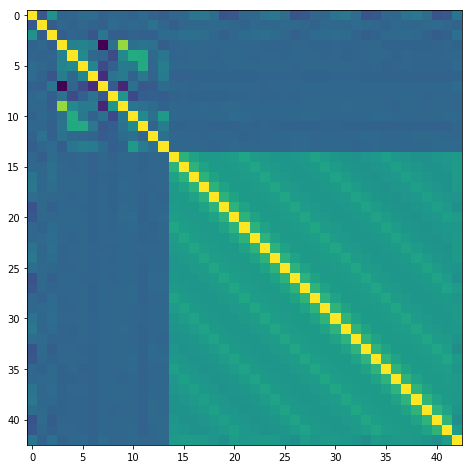

In [49]:
fig = plt.figure(figsize=(8, 8))
plt.clf()
plt.imshow(features_stdz.corr())

If the covariance matrix diverges from Identity, some eigenvectors may have a small magnitude, collapsing the corresponding axis of the Loss space. But, it's okay if you use `SGD` with a small learning rate, because you cannot examine the entire Hypothesis space. If repeated predictions result in similar minimization, we can be confident that it is close tothe global minimum.

## Write to file 

In [50]:
torch.manual_seed(1)

In [51]:
# Measure sizes
features = np.array(features_stdz)
S = 29
T = int(features.shape[0] / S)
Fe=features.shape[1]
H=Fe*S*2
batch_size=28 
num_epochs = 10

features_nn = features.reshape(T, S*Fe)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    features_nn
    , targets
    , test_size=0.25
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1522, 1247), (508, 1247), (1522, 29), (508, 29))

In [53]:
train_ds = DataLoader(
    torch.from_numpy(np.concatenate((X_train, y_train), axis=1))
    , batch_size=batch_size
    , drop_last=True
    , shuffle=True
    , 
)

test_ds = DataLoader(
    torch.from_numpy(np.concatenate((X_test, y_test), axis=1))
    , batch_size=batch_size
    , drop_last=True    
)

In [54]:
# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, feature_dim, hidden_dim, output_dim, num_layers, batch_size):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.feature_dim = feature_dim        
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim        
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_dim*feature_dim
            , self.hidden_dim
            , self.num_layers
            , dropout=0.3
            , batch_first=True
        )
        self.batchnorm1d_1 = nn.BatchNorm1d(batch_size)            
        self.linear_1 = nn.Linear(self.hidden_dim, int(self.hidden_dim/2))
        self.batchnorm1d_2 = nn.BatchNorm1d(batch_size)            
        self.linear_2 = nn.Linear(int(self.hidden_dim/2), output_dim)        
        
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.batchnorm1d_1(x)
        x = self.linear_1(x)
        x = F.relu(x)
        x = self.batchnorm1d_2(x)
        x = self.linear_2(x)        
        x = F.relu(x)        
        return x

In [55]:
model = LSTM(S, Fe, H, S, 2, batch_size)
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-5)
losses = []
#####################
# Train model
#####################
for t in range(num_epochs):
    # Clear stored gradient
    model.train()
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    model.hidden = model.init_hidden()
    for batch_idx, data in enumerate(train_ds):
        X_train_bf = data[:, :Fe*S].reshape(1, batch_size, Fe*S).type(torch.FloatTensor)
        y_train_bf = data[:, Fe*S:].type(torch.FloatTensor)
        model.zero_grad()
        # Forward pass        
        y_pred = model(X_train_bf)
        collapsed_size = torch.tensor(y_train_bf.shape).cumprod(dim=0)[-1].item()
        pred = y_pred.clone()
        pred = pred.view(collapsed_size)
        target = y_train_bf.view(collapsed_size)
        loss = loss_fn(
            pred
            , target
        )
        # Backward pass
        loss.backward()
        # Update parameters
        optimiser.step()
        losses.append(loss.item())
        if batch_idx % 25 == 0:
            loss_t = np.mean(losses[-25:])
            print(
                '[train] [e]:%s [b]:%s - [loss]:%s' \
                % (t, batch_idx, str(loss_t))
            )

[train] [e]:0 [b]:0 - [loss]:14.58961009979248
[train] [e]:0 [b]:25 - [loss]:11.980063571929932
[train] [e]:0 [b]:50 - [loss]:9.947536907196046
[train] [e]:1 [b]:0 - [loss]:10.47425106048584
[train] [e]:1 [b]:25 - [loss]:9.687105655670166
[train] [e]:1 [b]:50 - [loss]:9.791237392425536
[train] [e]:2 [b]:0 - [loss]:9.770022811889648
[train] [e]:2 [b]:25 - [loss]:9.277689590454102
[train] [e]:2 [b]:50 - [loss]:9.726202907562255
[train] [e]:3 [b]:0 - [loss]:9.574079761505127
[train] [e]:3 [b]:25 - [loss]:9.687850952148438
[train] [e]:3 [b]:50 - [loss]:9.193462829589844
[train] [e]:4 [b]:0 - [loss]:9.59652286529541
[train] [e]:4 [b]:25 - [loss]:9.57284336090088
[train] [e]:4 [b]:50 - [loss]:8.437732582092286
[train] [e]:5 [b]:0 - [loss]:8.931709842681885
[train] [e]:5 [b]:25 - [loss]:9.369365119934082
[train] [e]:5 [b]:50 - [loss]:8.261492214202882
[train] [e]:6 [b]:0 - [loss]:8.789466438293458
[train] [e]:6 [b]:25 - [loss]:9.053720722198486
[train] [e]:6 [b]:50 - [loss]:8.719581184387208


In [56]:
pred.mean(), target.mean(), pred.var(), target.var()

(tensor(1.9324, grad_fn=<MeanBackward1>),
 tensor(1.9002),
 tensor(2.5061, grad_fn=<VarBackward0>),
 tensor(8.4450))

The model does a reasonable job at estimating the mean, but fails to explain 2/3 of Variance. But, the prediction is not so bad.

#### Why?
This is because the events are naturally local events in time and space. The onset of noisy event gives rise to a sharp rise in the local complaint counts and a geometric decay with respect to time. They are also outliers because the days in which there are no noisy events greatly outnumber the noisy days. 

In [58]:
model.eval()
losses = []
preds = []
targets = []

with torch.no_grad():
    for batch_idx, data in enumerate(test_ds):
        X_test_bf = data[:, :Fe*S].reshape(1, batch_size, Fe*S).type(torch.FloatTensor)
        y_test_bf = data[:, Fe*S:].type(torch.FloatTensor)
        output = model(X_test_bf)
        collapsed_size = torch.tensor(y_test_bf.shape).cumprod(dim=0)[-1].item()
        pred = output.view(collapsed_size)
        preds.extend(pred)
        target = y_test_bf.view(collapsed_size)
        targets.extend(target)        
        loss = loss_fn(
            pred.squeeze()
            , target.squeeze()
        )
        losses.append(loss.item())
        loss_t = np.mean(losses[-1:])
        print(
            '[test] [b]:%s - [loss]:%s' \
            % (batch_idx, str(loss_t))
        )

[test] [b]:0 - [loss]:9.73703384399414
[test] [b]:1 - [loss]:8.130016326904297
[test] [b]:2 - [loss]:5.712056636810303
[test] [b]:3 - [loss]:8.204934120178223
[test] [b]:4 - [loss]:7.939121723175049
[test] [b]:5 - [loss]:7.4389190673828125
[test] [b]:6 - [loss]:7.740626335144043
[test] [b]:7 - [loss]:9.000847816467285
[test] [b]:8 - [loss]:7.571782112121582
[test] [b]:9 - [loss]:6.461048603057861
[test] [b]:10 - [loss]:7.0871453285217285
[test] [b]:11 - [loss]:4.6017069816589355
[test] [b]:12 - [loss]:9.532967567443848
[test] [b]:13 - [loss]:7.327911376953125
[test] [b]:14 - [loss]:8.2724609375
[test] [b]:15 - [loss]:6.229139804840088
[test] [b]:16 - [loss]:6.6791791915893555
[test] [b]:17 - [loss]:11.896109580993652


<Figure size 432x288 with 0 Axes>

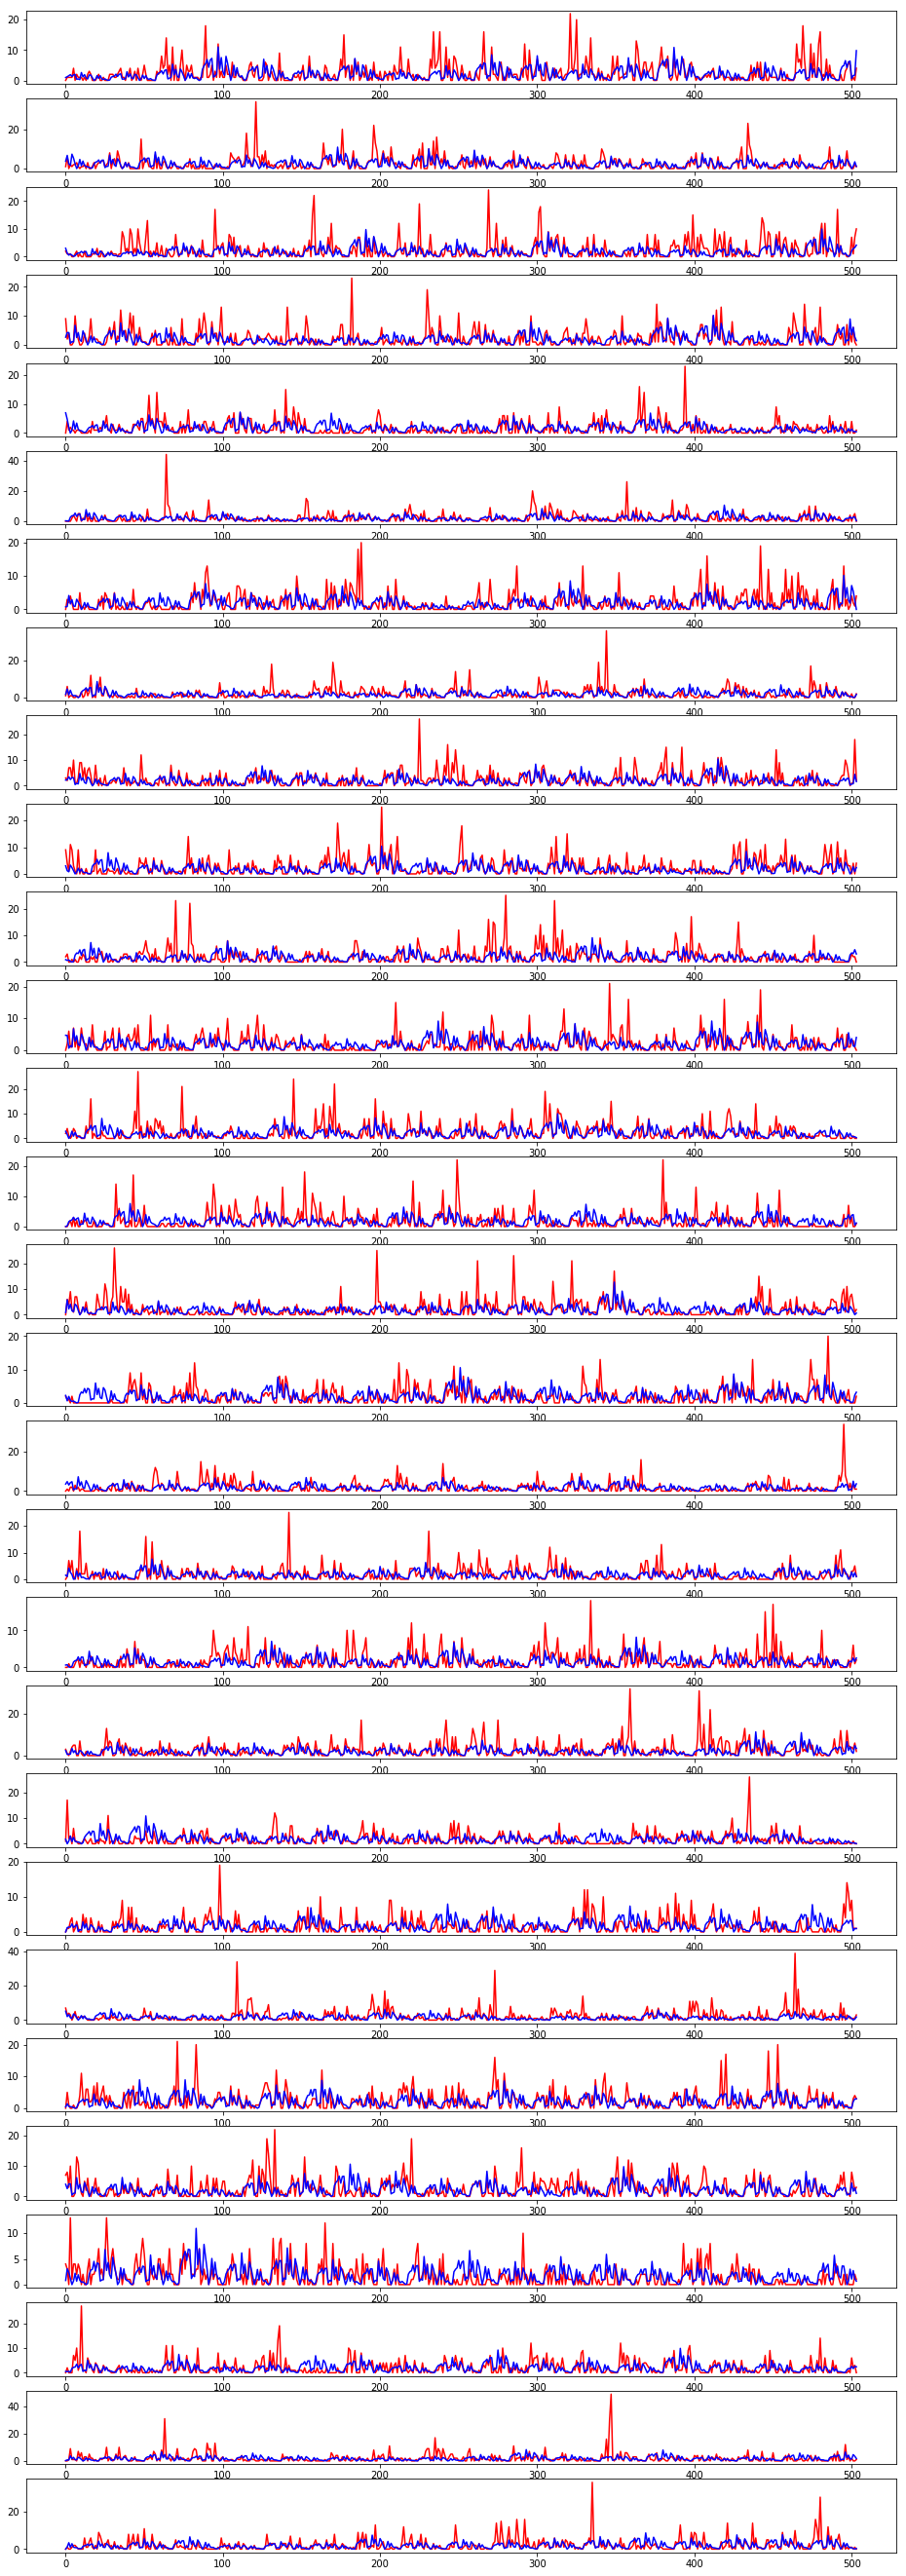

In [59]:
target_vals = np.array(targets).reshape(29, len(targets) // 29)
pred_vals = np.array(preds).reshape(29, len(targets) // 29)

plt.clf()
plt.tight_layout()
fig, axs = plt.subplots(S, 1, figsize=(16, 48))
for i in range(S):
    axs[i].plot(range(len(targets) // 29), target_vals[i], 'r-', pred_vals[i], 'b-')
    
    

# Bibliography

Menne, M.J., I. Durre, R.S. Vose, B.E. Gleason, and T.G. Houston, 2012:  An overview 
of the Global Historical Climatology Network-Daily Database.  Journal of Atmospheric 
and Oceanic Technology, 29, 897-910, doi:10.1175/JTECH-D-11-00103.1.